In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *
from fastai.models.resnet import vgg_resnet50

import json

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
from pycocotools.coco import COCO

In [4]:
torch.cuda.set_device(0)

In [5]:
torch.backends.cudnn.benchmark=True

In [6]:
from IPython.display import HTML
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/_dXqugxU1sk" frameborder="0" allow="autoplay; encrypted-media" allowfullscreen></iframe>')

In [9]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

## Data

In [10]:
PATH = Path('../data/coco')

In [50]:
JPEGS_TRN = 'train2017'
IMG_PATH_TRN = PATH/JPEGS_TRN

JPEGS_VAL = 'val2017'
IMG_PATH_VAL = PATH/JPEGS_VAL

MASK_TRN = 'person_mask_train'
MASK_PATH_TRN = PATH/MASK_TRN

MASK_VAL = 'person_mask_val'
MASK_PATH_VAL = PATH/MASK_VAL

In [12]:
coco_trn = COCO(PATH/'annotations/instances_train2017.json')

loading annotations into memory...
Done (t=15.87s)
creating index...
index created!


In [13]:
coco_val = COCO(PATH/'annotations/instances_val2017.json')

loading annotations into memory...
Done (t=0.56s)
creating index...
index created!


In [14]:
person_id = coco_trn.getCatIds(catNms=['person'])
img_ids_trn = coco_trn.getImgIds(catIds=person_id)
img_ids_val = coco_val.getImgIds(catIds=person_id)

In [16]:
trn_ims = coco_trn.loadImgs(img_ids_trn)
val_ims = coco_val.loadImgs(img_ids_val)

In [47]:
def create_masks(coco_ob, im_obs, PTH):
    PTH = Path(PTH)
    if not PTH.exists(): PTH.mkdir()
    for im in tqdm(im_obs):    
        annIds = coco_ob.getAnnIds(imgIds=im['id'], catIds=person_id, iscrowd=None)
        anns = coco_ob.loadAnns(annIds)

        mask = np.zeros((im['height'], im['width']))

        for ann in anns:
            mask += coco_ob.annToMask(ann)

        mask = (mask > 0).astype('uint8')
        fn_stem = im['file_name'].split('.')[0]
        dst = str(PTH/(fn_stem + '.png'))

        cv2.imwrite(dst, mask*255)


In [48]:
create_masks(coco_val, val_ims, MASK_PATH_VAL)

100%|██████████| 2693/2693 [00:13<00:00, 202.05it/s]


In [49]:
create_masks(coco_trn, trn_ims, MASK_PATH_TRN)

100%|██████████| 64115/64115 [05:20<00:00, 200.22it/s]


In [55]:
sz = 128
bs = 64
nw = 8

In [56]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): return open_image(os.path.join(self.path, self.y[i]))
    def get_c(self): return 0

In [71]:
JPEGS_TRN

'train2017'

In [70]:
IMG_PATH_TRN

PosixPath('../data/coco/train2017')

In [76]:
trn_x = np.array([Path(JPEGS_TRN)/im['file_name'] for im in trn_ims])
val_x = np.array([Path(JPEGS_VAL)/im['file_name'] for im in val_ims])

In [79]:
trn_y = np.array([Path(MASK_TRN)/(im.stem+'.png') for im in trn_x])
val_y = np.array([Path(MASK_VAL)/(im.stem+'.png') for im in val_x])

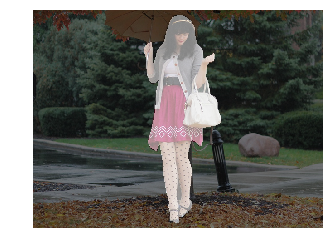

In [80]:
idx = 10
ax = show_img(open_image(PATH/val_x[idx]))
show_img(open_image(PATH/val_y[idx]), ax=ax, alpha=0.5)

In [81]:
aug_tfms = [RandomRotate(4, tfm_y=TfmType.CLASS),
            RandomFlip(tfm_y=TfmType.CLASS),
            RandomLighting(0.05, 0.05, tfm_y=TfmType.CLASS)]

In [82]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=nw, classes=None)
denorm = md.trn_ds.denorm

In [83]:
x,y = next(iter(md.trn_dl))

In [84]:
x.shape,y.shape

(torch.Size([64, 3, 128, 128]), torch.Size([64, 128, 128]))

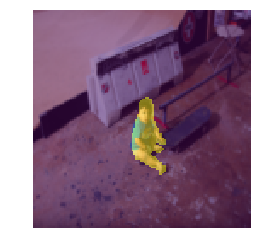

In [86]:
ax = show_img(denorm(x)[0])
show_img(y[0], ax = ax, alpha=0.5)

In [87]:
f = resnet34
cut,lr_cut = model_meta[f]

In [88]:
def get_base():
    layers = cut_model(f(True), cut)
    return nn.Sequential(*layers)

In [89]:
def dice(pred, targs):
    pred = (pred>0).float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()

## U-net (ish)

In [90]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [91]:
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p))

In [92]:
class Unet34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(512,256,256)
        self.up2 = UnetBlock(256,128,256)
        self.up3 = UnetBlock(256,64,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5 = nn.ConvTranspose2d(256, 1, 2, stride=2)
        
    def forward(self,x):
        x = F.relu(self.rn(x))
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x)
        return x[:,0]
    
    def close(self):
        for sf in self.sfs: sf.remove()

In [93]:
class UnetModel():
    def __init__(self,model,name='unet'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model)[1:]]

In [94]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [95]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5),dice]

In [96]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 128, 128]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 32, 32]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 32, 32]),
      

In [97]:
[o.features.size() for o in m.sfs]

[torch.Size([3, 64, 64, 64]),
 torch.Size([3, 64, 32, 32]),
 torch.Size([3, 128, 16, 16]),
 torch.Size([3, 256, 8, 8])]

In [98]:
learn.freeze_to(1)

 78%|███████▊  | 778/1002 [03:30<01:00,  3.69it/s, loss=0.381]

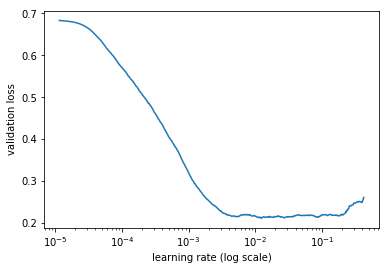

In [99]:
learn.lr_find()
learn.sched.plot()

In [100]:
lr=1e-3
# wd=1e-7

lrs = np.array([lr/100,lr/10,lr])

In [101]:
learn.fit(lr,1,cycle_len=8,use_clr=(5,8))

epoch      trn_loss   val_loss   <lambda>   dice       
    0      0.170488   0.165438   0.928325   0.782957  
    1      0.151258   0.153709   0.933449   0.801031  
    2      0.14272    0.147926   0.937667   0.814549  
    3      0.134284   0.144645   0.939366   0.818379  
    4      0.126677   0.14003    0.941221   0.825166  
    5      0.12112    0.140777   0.94147    0.825991  
    6      0.111376   0.139491   0.94136    0.82594   
    7      0.10752    0.140974   0.94229    0.827712  


[array([0.14097]), 0.9422899565641826, 0.827711949091128]

In [102]:
learn.save('128urn-tmp')

In [103]:
learn.load('128urn-tmp')

In [37]:
learn.unfreeze()
learn.bn_freeze(True)

 52%|█████▏    | 291/563 [01:21<01:15,  3.59it/s, loss=0.352]

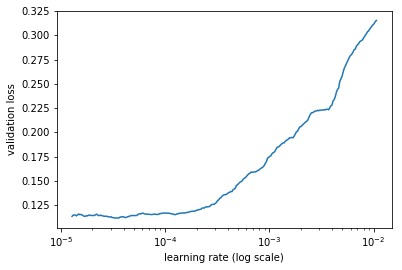

In [38]:
learn.lr_find()
learn.sched.plot()

In [39]:
lr=1e-5
# wd=1e-7

lrs = np.array([lr/100,lr/10,lr])

In [40]:
learn.fit(lrs, 1, cycle_len=20,use_clr=(20,10))

epoch      trn_loss   val_loss   <lambda>   dice       
    0      0.114449   0.146926   0.936501   0.805704  
    1      0.113183   0.146307   0.937567   0.809017  
    2      0.113302   0.14616    0.938035   0.810354  
    3      0.112891   0.146137   0.938288   0.811067  
 50%|█████     | 282/563 [01:20<01:20,  3.49it/s, loss=0.113]

KeyboardInterrupt: 

In [41]:
learn.save('128urn-0')

In [42]:
learn.load('128urn-0')

In [104]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

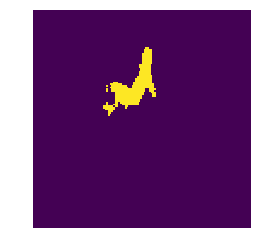

In [105]:
idx = 5
show_img(py[idx]>0)

In [106]:
out = denorm(x)[idx]

In [107]:
mask = to_np(py[idx]>0).astype('float32')

In [108]:
wn_mat = np.random.uniform(0.5,1, mask.shape)

In [109]:
kernel = np.ones((5,5),np.float32)/25
wn_mat = cv2.filter2D(wn_mat,-1,kernel)[:,:,None]

In [110]:
out[np.where(mask==1)] = wn_mat[np.where(mask==1)]

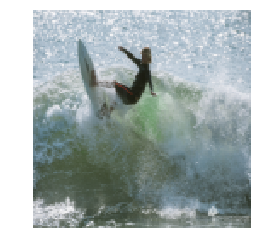

In [111]:
show_img(denorm(x)[idx])

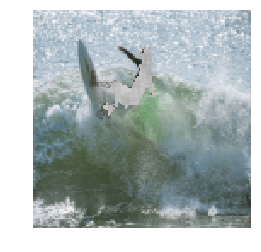

In [112]:
#ax = show_img(denorm(x)[1])
show_img(out)

In [113]:
out = denorm(x)[idx]

In [114]:
mask = to_np(py[idx]>0).astype('float32')

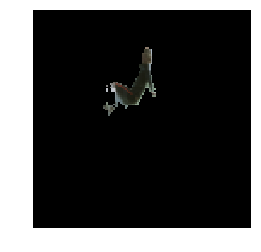

In [115]:
show_img(mask[:,:,None] * out)

In [116]:
m.close()

## 512x512

In [125]:
sz=512
bs=16

In [132]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=8, classes=None)
denorm = md.trn_ds.denorm

In [133]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [134]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5),dice]

In [135]:
learn.freeze_to(1)

In [136]:
learn.load('128urn-tmp')

 68%|██████▊   | 2735/4008 [26:35<12:22,  1.71it/s, loss=0.439]

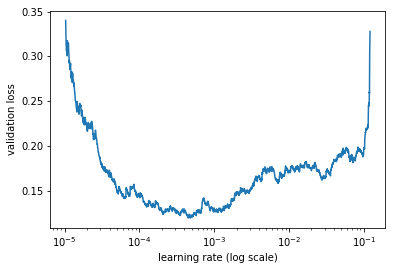

In [137]:
learn.lr_find()
learn.sched.plot()

In [138]:
lr=1e-4

In [139]:
learn.fit(lr, 1, cycle_len=5,use_clr=(5,5))

epoch      trn_loss   val_loss   <lambda>   dice       
    0      0.104472   0.106686   0.95691    0.86972   
    1      0.102342   0.100488   0.958281   0.874992  
    2      0.101425   0.099066   0.955873   0.873428  
    3      0.085514   0.093895   0.961295   0.884002  
    4      0.080591   0.09409    0.960828   0.883533  


[array([0.09409]), 0.9608277420638177, 0.8835333311578343]

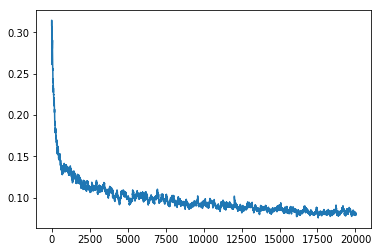

In [149]:
learn.sched.plot_loss()

In [145]:
learn.save(f'dimview_last_{sz}')

In [147]:
learn.load(f'dimview_last_{sz}')

In [178]:
import dill as dill
torch.save(learn.model, f'../data/coco/deploy_models/dimview_last_{sz}.h5', pickle_module=dill)

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/serialization.py:159: UserWarning: Couldn't retrieve source code for container of type Unet34. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/serialization.py:159: UserWarning: Couldn't retrieve source code for container of type UnetBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [ ]:
!rm -rf exp

In [ ]:
learn.unfreeze()
learn.bn_freeze(True)

In [ ]:
learn.lr_find()
learn.sched.plot()

In [ ]:
lr = 1e-5
lrs = np.array([lr/100,lr/10,lr])

In [ ]:
learn.fit(lrs/4,1, cycle_len=8,use_clr=(20,8))

In [ ]:
learn.save('512urn')

In [26]:
learn.load('512urn')

In [150]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

In [151]:
idx=0

In [172]:
idx+=1

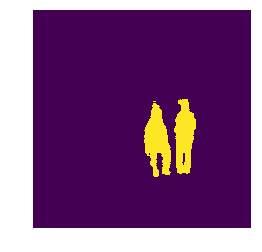

In [173]:
show_img(py[idx]>0);

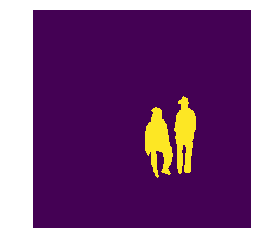

In [174]:
show_img(y[idx]);

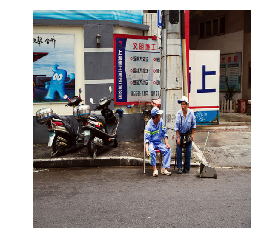

In [175]:
show_img(denorm(x)[idx])

In [78]:
m.close()

## 1024x1024

In [26]:
sz=1024
bs=4

In [27]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)
denorm = md.trn_ds.denorm

In [28]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [29]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5),dice]

In [30]:
learn.load('512urn')

In [31]:
learn.freeze_to(1)

In [32]:
learn.fit(lr,1, wds=wd, cycle_len=2,use_clr=(5,4))

epoch      trn_loss   val_loss   <lambda>   dice                 
    0      0.007656   0.008155   0.997247   0.99353   
    1      0.004706   0.00509    0.998039   0.995437             



[0.005090427414942828, 0.9980387706605215, 0.995437301104031]

In [33]:
learn.save('1024urn-tmp')

In [30]:
learn.load('1024urn-tmp')

In [31]:
learn.unfreeze()
learn.bn_freeze(True)

In [32]:
lrs = np.array([lr/200,lr/30,lr])

In [33]:
learn.fit(lrs/10,1, wds=wd,cycle_len=4,use_clr=(20,8))

epoch      trn_loss   val_loss   <lambda>   dice                 
    0      0.005688   0.006135   0.997616   0.994616  
    1      0.004412   0.005223   0.997983   0.995349             
    2      0.004186   0.004975   0.99806    0.99554              
    3      0.004016   0.004899   0.99812    0.995627             



[0.004898778487196458, 0.9981196409180051, 0.9956271404784823]

In [33]:
learn.fit(lrs/10,1, wds=wd,cycle_len=4,use_clr=(20,8))

epoch      trn_loss   val_loss   <lambda>   dice                 
    0      0.004169   0.004962   0.998049   0.995517  
    1      0.004022   0.004595   0.99823    0.995818             
    2      0.003772   0.004497   0.998215   0.995916             
    3      0.003618   0.004435   0.998291   0.995991             



[0.004434524739663753, 0.9982911745707194, 0.9959913929776539]

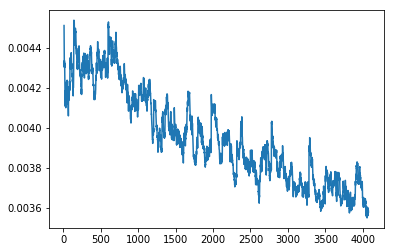

In [34]:
learn.sched.plot_loss()

In [35]:
learn.save('1024urn')

In [26]:
learn.load('1024urn')

In [36]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

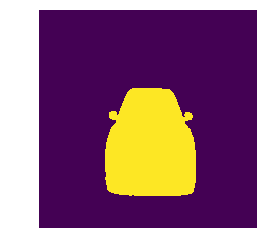

In [37]:
show_img(py[0]>0);

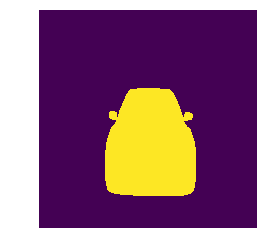

In [38]:
show_img(y[0]);